In [1]:
#import some necessary librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
from sklearn.model_selection import train_test_split


from scipy import stats
from scipy.stats import norm, skew #for some statistics# data processing, CSV file I/O (e.g. pd.read_csv)

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000,0,0,211536,13.000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000,0,0,112053,30.000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.450,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000,0,0,111369,30.000,C148,C


In [3]:
train_ID = train['PassengerId']
test_ID = test['PassengerId']

train.drop('PassengerId', axis = 1, inplace = True)
test.drop('PassengerId', axis = 1, inplace = True)

# EDA and Data Processing

In [4]:
def missingdata(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    ms=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    ms= ms[ms["Percent"] > 0]
    f,ax =plt.subplots(figsize=(8,6))
    plt.xticks(rotation='90')
    fig=sns.barplot(ms.index, ms["Percent"],color="green",alpha=0.8)
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of missing values', fontsize=15)
    plt.title('Percent missing data by feature', fontsize=15)
    return ms

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

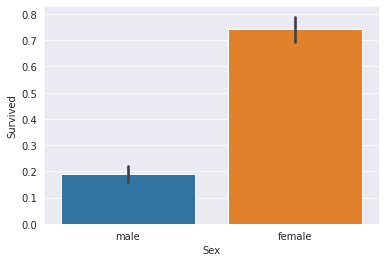

In [5]:
sns.barplot(train['Sex'], train['Survived'])

<AxesSubplot:xlabel='Pclass', ylabel='Fare'>

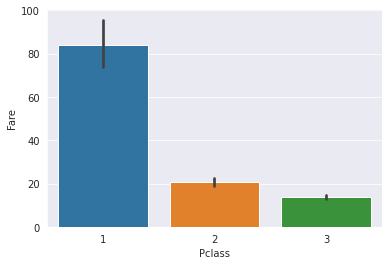

In [6]:
sns.barplot(train['Pclass'], train['Fare'])

<AxesSubplot:>

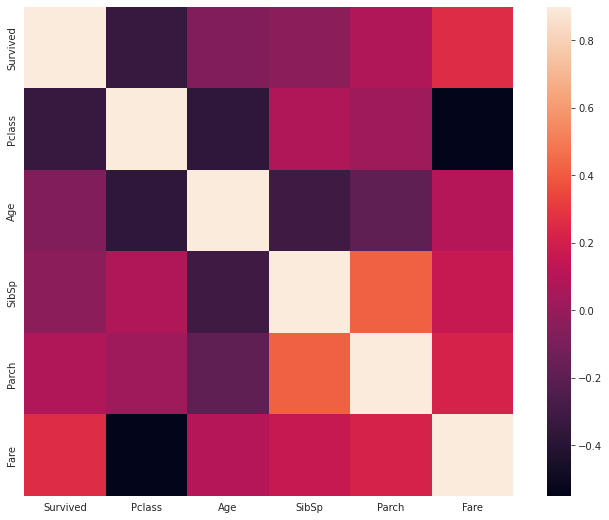

In [7]:
#create a heatmap to see how features correleate with data

#Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [8]:
ntrain = train.shape[0]
ntest = test.shape[0]
y = train.Survived.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['Survived'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (1309, 10)


,Total,Percent
Cabin,1014,77.464
Age,263,20.092
Embarked,2,0.153
Fare,1,0.076


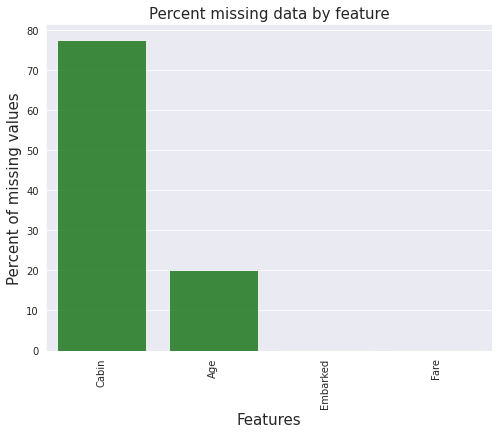

In [9]:
missingdata(all_data)

## Cleaning the Data

In [10]:
all_data['Embarked'] = all_data['Embarked'].fillna(all_data['Embarked'].mode()[0])

In [11]:
#Fill in missing values for Fare based on Pclass
fare = train.groupby("Pclass")["Fare"].median().values.tolist()
ticket_class = [1,2,3]
fare_ticket_class = {}
for tclass in ticket_class:
    fare_ticket_class[tclass] = fare[ticket_class.index(tclass)]
all_data["Fare"] = all_data.groupby("Pclass")["Fare"].transform(
    lambda x: x.fillna(fare_ticket_class[x.name]))

In [12]:
all_data.Cabin = all_data.Cabin.fillna('Unknown_Cabin')
all_data['Cabin'] = all_data['Cabin'].str[0]

In [13]:
all_data.groupby('Pclass').Cabin.value_counts()

Pclass  Cabin
1       C         94
        U         67
        B         65
        D         40
        E         34
        A         22
        T          1
2       U        254
        F         13
        D          6
        E          4
3       U        693
        F          8
        G          5
        E          3
Name: Cabin, dtype: int64

In [14]:
all_data['Cabin'] = np.where((all_data.Pclass==1) & (all_data.Cabin=='U'),'C', 
                             np.where((all_data.Pclass==2) & (all_data.Cabin=='U'),'D',
                             np.where((all_data.Pclass==3) & (all_data.Cabin=='U'),'G',
                             np.where(all_data.Cabin=='T','C',all_data.Cabin))))

In [15]:
import re
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Create a new feature Title, containing the titles of passenger names
all_data['Title'] = all_data['Name'].apply(get_title)

# Group all non-common titles into one single grouping "Rare"
all_data['Title'] = all_data['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 
                                              'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
all_data['Title'] = all_data['Title'].replace('Mlle', 'Miss')
all_data['Title'] = all_data['Title'].replace('Ms', 'Miss')
all_data['Title'] = all_data['Title'].replace('Mme', 'Mrs')

all_data.drop('Name', axis = 1, inplace = True)

In [16]:
all_data

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,3,male,22.000,1,0,A/5 21171,7.250,G,S,Mr
1,1,female,38.000,1,0,PC 17599,71.283,C,C,Mrs
2,3,female,26.000,0,0,STON/O2. 3101282,7.925,G,S,Miss
3,1,female,35.000,1,0,113803,53.100,C,S,Mrs
4,3,male,35.000,0,0,373450,8.050,G,S,Mr
...,...,...,...,...,...,...,...,...,...,...
1304,3,male,NaN,0,0,A.5. 3236,8.050,G,S,Mr
1305,1,female,39.000,0,0,PC 17758,108.900,C,C,Rare
1306,3,male,38.500,0,0,SOTON/O.Q. 3101262,7.250,G,S,Mr
1307,3,male,NaN,0,0,359309,8.050,G,S,Mr


In [17]:
train = all_data[:ntrain]

In [18]:
train.groupby('Title').Age.mean()

Title
Dr       42.000
Master    4.574
Miss     21.846
Mr       32.368
Mrs      35.789
Rare     46.875
Name: Age, dtype: float64

In [19]:
all_data['Age'] = np.where((all_data.Age.isnull()) & (all_data.Title=='Master'),7,
                        np.where((all_data.Age.isnull()) & (all_data.Title=='Miss'),23,
                                 np.where((all_data.Age.isnull()) & (all_data.Title=='Mr'),31,
                                          np.where((all_data.Age.isnull()) & (all_data.Title=='Mrs'),35,
                                                  np.where((all_data.Age.isnull()) & (all_data.Title=='Rare'),47,
                                                           np.where((all_data.Age.isnull()) & (all_data.Title=='Dr'), 40,all_data.Age))))))

In [20]:
all_data

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,3,male,22.000,1,0,A/5 21171,7.250,G,S,Mr
1,1,female,38.000,1,0,PC 17599,71.283,C,C,Mrs
2,3,female,26.000,0,0,STON/O2. 3101282,7.925,G,S,Miss
3,1,female,35.000,1,0,113803,53.100,C,S,Mrs
4,3,male,35.000,0,0,373450,8.050,G,S,Mr
...,...,...,...,...,...,...,...,...,...,...
1304,3,male,31.000,0,0,A.5. 3236,8.050,G,S,Mr
1305,1,female,39.000,0,0,PC 17758,108.900,C,C,Rare
1306,3,male,38.500,0,0,SOTON/O.Q. 3101262,7.250,G,S,Mr
1307,3,male,31.000,0,0,359309,8.050,G,S,Mr


## Feature Engineering

In [21]:
all_data['FamilySize'] = all_data['SibSp'] + all_data['Parch'] + 1
all_data['Mother'] = np.where((all_data.Title=='Mrs') & (all_data.Parch >0),1,0)
all_data['Free'] = np.where(all_data['Fare']==0, 1,0)
all_data = all_data.drop(['SibSp','Parch','Sex'],axis=1)

In [22]:
import string
TypeOfTicket = []
for i in range(len(all_data.Ticket)):
    ticket = all_data.Ticket.iloc[i]
    for c in string.punctuation:
                ticket = ticket.replace(c,"")
                splited_ticket = ticket.split(" ")   
    if len(splited_ticket) == 1:
                TypeOfTicket.append('NO')
    else: 
                TypeOfTicket.append(splited_ticket[0])
            
all_data['TypeOfTicket'] = TypeOfTicket

all_data.TypeOfTicket.value_counts()
all_data['TypeOfTicket'] = np.where((all_data.TypeOfTicket!='NO') & (all_data.TypeOfTicket!='PC') & (all_data.TypeOfTicket!='CA') & 
                                (all_data.TypeOfTicket!='A5') & (all_data.TypeOfTicket!='SOTONOQ'),'other',all_data.TypeOfTicket)
all_data = all_data.drop('Ticket',axis=1)

In [23]:
all_data

,Pclass,Age,Fare,Cabin,Embarked,Title,FamilySize,Mother,Free,TypeOfTicket
0,3,22.000,7.250,G,S,Mr,2,0,0,A5
1,1,38.000,71.283,C,C,Mrs,2,0,0,PC
2,3,26.000,7.925,G,S,Miss,1,0,0,other
3,1,35.000,53.100,C,S,Mrs,2,0,0,NO
4,3,35.000,8.050,G,S,Mr,1,0,0,NO
...,...,...,...,...,...,...,...,...,...,...
1304,3,31.000,8.050,G,S,Mr,1,0,0,A5
1305,1,39.000,108.900,C,C,Rare,1,0,0,PC
1306,3,38.500,7.250,G,S,Mr,1,0,0,SOTONOQ
1307,3,31.000,8.050,G,S,Mr,1,0,0,NO


In [24]:
## create bin for age features
all_data['Age_bin'] = pd.cut(all_data['Age'], bins=[0,12,20,40,120], labels=['Children','Teenage','Adult','Elder'])
all_data['Fare_bin'] = pd.cut(all_data['Fare'], include_lowest=True, bins=[-0.513, 7.9, 14.5, 30.5, 513], labels=['Low_fare','median_fare','Average_fare','high_fare'])



In [25]:
all_data = pd.get_dummies(all_data)

In [26]:
all_data

,Pclass,Age,Fare,FamilySize,Mother,Free,Cabin_A,Cabin_B,Cabin_C,Cabin_D,...,TypeOfTicket_SOTONOQ,TypeOfTicket_other,Age_bin_Children,Age_bin_Teenage,Age_bin_Adult,Age_bin_Elder,Fare_bin_Low_fare,Fare_bin_median_fare,Fare_bin_Average_fare,Fare_bin_high_fare
0,3,22.000,7.250,2,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
1,1,38.000,71.283,2,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
2,3,26.000,7.925,1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
3,1,35.000,53.100,2,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
4,3,35.000,8.050,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,31.000,8.050,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1305,1,39.000,108.900,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
1306,3,38.500,7.250,1,0,0,0,0,0,0,...,1,0,0,0,1,0,1,0,0,0
1307,3,31.000,8.050,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [27]:
# Get new cleaned train and test data
train = all_data[:ntrain]
test = all_data[ntrain:]

In [28]:
train

,Pclass,Age,Fare,FamilySize,Mother,Free,Cabin_A,Cabin_B,Cabin_C,Cabin_D,...,TypeOfTicket_SOTONOQ,TypeOfTicket_other,Age_bin_Children,Age_bin_Teenage,Age_bin_Adult,Age_bin_Elder,Fare_bin_Low_fare,Fare_bin_median_fare,Fare_bin_Average_fare,Fare_bin_high_fare
0,3,22.000,7.250,2,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
1,1,38.000,71.283,2,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
2,3,26.000,7.925,1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
3,1,35.000,53.100,2,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
4,3,35.000,8.050,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,27.000,13.000,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
887,1,19.000,30.000,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
888,3,23.000,23.450,4,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
889,1,26.000,30.000,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0


# Modeling

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.ensemble import StackingClassifier

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

In [30]:
X_train, X_valid, y_train, y_valid = train_test_split(train, y, test_size=0.30, random_state=2019)
Results = pd.DataFrame({'Model': [],'Accuracy Score': [], 'Recall':[], 'F1score':[]})


In [31]:
dt_model = DecisionTreeClassifier(max_depth=4)
dt_model.fit(X_train, y_train)
pred = dt_model.predict(X_valid)
res = pd.DataFrame({"Model":['DecisionTreeClassifier'],
                    "Accuracy Score": [accuracy_score(pred,y_valid)],
                   "Recall": [recall_score(y_valid, pred)],
                   "F1score": [f1_score(y_valid, pred)]})
Results = Results.append(res)
print('DONE')

DONE


In [32]:
pd.crosstab(y_valid, pred, rownames=['Real data'], colnames=['Predicted'])

Predicted,0,1
Real data,,
0,151,25
1,20,72


In [33]:
rf_model = RandomForestClassifier(n_estimators=2500, max_depth=4)
rf_model.fit(X_train, y_train)
pred = rf_model.predict(X_valid)
res = pd.DataFrame({"Model":['RandomForestClassifier'],
                    "Accuracy Score": [accuracy_score(pred,y_valid)],
                   "Recall": [recall_score(y_valid, pred)],
                   "F1score": [f1_score(y_valid, pred)]})
Results = Results.append(res)
print('DONE')

DONE


In [34]:
pd.crosstab(y_valid, pred, rownames=['Real data'], colnames=['Predicted'])

Predicted,0,1
Real data,,
0,162,14
1,28,64


In [35]:
knc_model = KNeighborsClassifier()
knc_model.fit(X_train, y_train)
pred = knc_model.predict(X_valid)
res = pd.DataFrame({"Model":['KNeighborsClassifier'],
                    "Accuracy Score": [accuracy_score(pred,y_valid)],
                   "Recall": [recall_score(y_valid, pred)],
                   "F1score": [f1_score(y_valid, pred)]})
Results = Results.append(res)
print('DONE')

DONE


In [36]:
pd.crosstab(y_valid, pred, rownames=['Real data'], colnames=['Predicted'])

Predicted,0,1
Real data,,
0,137,39
1,41,51


In [37]:
svc_model = SVC()
svc_model.fit(X_train, y_train)
pred = svc_model.predict(X_valid)
res = pd.DataFrame({"Model":['SVC'],
                    "Accuracy Score": [accuracy_score(pred,y_valid)],
                   "Recall": [recall_score(y_valid, pred)],
                   "F1score": [f1_score(y_valid, pred)]})
Results = Results.append(res)
print('DONE')

DONE


In [38]:
pd.crosstab(y_valid, pred, rownames=['Real data'], colnames=['Predicted'])

Predicted,0,1
Real data,,
0,154,22
1,58,34


In [39]:
log_model = LogisticRegression(solver='liblinear')
log_model.fit(X_train, y_train)
pred = log_model.predict(X_valid)
res = pd.DataFrame({"Model":['LogisticRegression'],
                    "Accuracy Score": [accuracy_score(pred,y_valid)],
                   "Recall": [recall_score(y_valid, pred)],
                   "F1score": [f1_score(y_valid, pred)]})
Results = Results.append(res)
print('DONE')

DONE


In [40]:
pd.crosstab(y_valid, pred, rownames=['Real data'], colnames=['Predicted'])

Predicted,0,1
Real data,,
0,153,23
1,23,69


In [41]:
xgb_model = XGBClassifier(learning_rate=0.001,n_estimators=2500,
                                max_depth=4, min_child_weight=0,
                                gamma=0, subsample=0.7,
                                colsample_bytree=0.7,
                                scale_pos_weight=1, seed=27,
                                reg_alpha=0.00006, objective = 'binary:logistic')
xgb_model.fit(X_train, y_train)
pred = xgb_model.predict(X_valid)
res = pd.DataFrame({"Model":['XGBClassifier'],
                    "Accuracy Score": [accuracy_score(pred,y_valid)],
                   "Recall": [recall_score(y_valid, pred)],
                   "F1score": [f1_score(y_valid, pred)]})
Results = Results.append(res)
print('DONE')

[00:55:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
DONE


In [42]:
pd.crosstab(y_valid, pred, rownames=['Real data'], colnames=['Predicted'])

Predicted,0,1
Real data,,
0,156,20
1,22,70


In [43]:
Results

,Model,Accuracy Score,Recall,F1score
0,DecisionTreeClassifier,0.832,0.783,0.762
0,RandomForestClassifier,0.843,0.696,0.753
0,KNeighborsClassifier,0.701,0.554,0.560
0,SVC,0.701,0.370,0.459
0,LogisticRegression,0.828,0.750,0.750
0,XGBClassifier,0.843,0.761,0.769


# Hyperparameter Optimization

In [44]:
#Random Forest Hyperparameter Tuning

"""from sklearn.model_selection import GridSearchCV


gs_model = RandomForestClassifier()

params = { 'n_estimators': [3000, 3500, 4000],
          'max_depth' : [10]
         }


gs = GridSearchCV(gs_model, params,scoring='neg_mean_absolute_error',)

gs.fit(X_train, y_train)

print("Best parameters:", gs.best_params_)
print("Lowest MAE: ", (-gs.best_score_))"""
#n_estimators - 3000, max_depth - 10

'from sklearn.model_selection import GridSearchCV\n\n\ngs_model = RandomForestClassifier()\n\nparams = { \'n_estimators\': [3000, 3500, 4000],\n          \'max_depth\' : [10]\n         }\n\n\ngs = GridSearchCV(gs_model, params,scoring=\'neg_mean_absolute_error\',)\n\ngs.fit(X_train, y_train)\n\nprint("Best parameters:", gs.best_params_)\nprint("Lowest MAE: ", (-gs.best_score_))'

## Stacking Models

In [45]:
stacked_model = StackingClassifier(estimators = [('xgb', xgb_model), ('rf', rf_model), ('dt', dt_model), ('logistic', log_model)], final_estimator = xgb_model, cv=5)

stacked_model.fit(X_train, y_train)
stacked_model_pred = stacked_model.predict(X_valid)
score = accuracy_score(stacked_model_pred,y_valid)
print(" Averaged base models score: {:.4f}\n".format(score))
# 0.8582 #0.8358

[00:55:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:55:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:55:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:55:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

# Submission

In [46]:
stacked_model.fit(train, y)

[00:56:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:56:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:56:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:57:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

StackingClassifier(cv=5,
                   estimators=[('xgb',
                                XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=0.7,
                                              enable_categorical=False, gamma=0,
                                              gpu_id=-1, importance_type=None,
                                              interaction_constraints='',
                                              learning_rate=0.001,
                                              max_delta_step=0, max_depth=4,
                                              min_child_weight=0, missing=nan,
                                              monotone_constraints='()',
                                              n_es...
                                                 importance_type=None,


In [47]:
final_preds = stacked_model.predict(test)

In [48]:
# Run the code to save predictions in the format used for competition scoring

output = pd.DataFrame({'PassengerId': test_ID,
                       'Survived': final_preds})
output.to_csv('submission.csv', index=False)
print("Done")

Done


In [49]:
output

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
